<h5>Importing libraries</h5>

In [11]:
#data handling
import pandas as pd
import numpy as np
import os 
from PIL import Image

# Machine learning 
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# misc
import time # for recording how long models took to train for later comparison
import multiprocessing # for speeding up training time, needed for some of the larger cross validation methods


<h5>Read in images into numpy arrays and record type of tumor with one hot encoder</h5>

In [12]:
img_reshape_size = (32,32)

data = []
result = []

# path to non tumor files
no_tumor_image_dir = "dataset/split_data/binary/no_tumor"
no_tumor_files = os.listdir(no_tumor_image_dir)

# path to tumor files
tumor_image_dir = "dataset/split_data/binary/tumor"
tumor_files = os.listdir(tumor_image_dir)

for file in no_tumor_files:
    temp_file_path = "dataset/split_data/binary/no_tumor/"+file # create path to image
    #print("path is " +temp_file_path)
    img = Image.open(temp_file_path).convert('L') # not an RGB image so import as greyscale
    img = img.resize(img_reshape_size) # reshape image (downscale) to reduce playtime
    img = np.array(img) # convert to numpy array
    img = img.flatten() # flattern to 1D array for model input
    data.append(np.array(img)) # add to data input array
    result.append(0) # record no tumor in result array

for file in tumor_files:
    temp_file_path = "dataset/split_data/binary/tumor/"+file # create path to image
    img = Image.open(temp_file_path).convert('L') # not an RGB image so import as greyscale
    img = img.resize(img_reshape_size) # reshape image (downscale) to reduce playtime
    img = np.array(img) # convert to numpy array
    img = img.flatten() # flattern to 1D array for model input
    data.append(np.array(img)) # add to data input array
    result.append(1) # record no tumor in result array

<h5>Reshape data and split between test and train data</h5>

In [13]:
data = np.asarray(data)
print(data.shape)
result=np.asarray(result)
print(result.shape)

(3000, 1024)
(3000,)


<h5>Define parameter grid and set multicore up</h5>

In [30]:
param_grid={"C":[0.001,0.01,0.1,1],"gamma":[0.01,0.1,1,10],"kernel":["rbf","sigmoid","poly"]} # create param grid for optimisation 

svc=svm.SVC(probability=True) # to allow for plotting and probability recording
cores=multiprocessing.cpu_count()-2 # leaving some cores free
model=GridSearchCV(svc, param_grid, verbose=10, n_jobs=cores, scoring = 'accuracy') # create the gridsearchCV


# tried a couple of different classifiers

#grid={"penalty":["l1","l2"]}# l1 lasso l2 ridge
#lgc=LogisticRegression( max_iter=10000)
#logreg_cv=GridSearchCV(lgc,grid,cv=10)
#model=GridSearchCV(logreg_cv,grid, verbose = True)
#lgc.fit(x_train, y_train )
#lgc.score(x_test,y_test)

<h5>Split the data into the same size as the CNN for comparision</h5>

In [31]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=1) # shuffle data and split for own testing purposes, give random state for reproducability 

<h5>Fit the model and record time</h5>

In [32]:
start_time = time.time()
model.fit(x_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
--- 289.13345742225647 seconds ---


<h5>Recording some meta data quickly</h5>

RGB images<br>
Fitting 5 folds for each of 48 candidates, totalling 240 fits<br>
--- 749.3267393112183 seconds ---<br> ~12 min

Greyscale image <br>
Fitting 5 folds for each of 48 candidates, totalling 240 fits<br>
--- 229.12096786499023 seconds ---<br> <4min

<h5>Get the model performance and the best parameters for the grid search</h5>

In [33]:
print(model.score(x_test,y_test)) # test on uneseen data - before validation set was released
print(model.best_params_) # print optimal parameters

0.9453333333333334
{'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}


<h5>Read in the unseen validation data</h5>

In [34]:
img_reshape_size = (32,32)

test_data = []
test_result = []

# path to non tumor files
no_tumor_image_dir = "test_dataset/test/split_data/binary/no_tumor"
no_tumor_files = os.listdir(no_tumor_image_dir)

# path to tumor files
tumor_image_dir = "test_dataset/test/split_data/binary/tumor"
tumor_files = os.listdir(tumor_image_dir)

for file in no_tumor_files:
    temp_file_path = "test_dataset/test/split_data/binary/no_tumor/"+file
    #print("path is " +temp_file_path)
    img = Image.open(temp_file_path).convert('L') # not an RGB image so import as greyscale
    img = img.resize(img_reshape_size)
    img = np.array(img)
    img = img.flatten()
    test_data.append(np.array(img))
    test_result.append(0)

for file in tumor_files:
    temp_file_path = "test_dataset/test/split_data/binary/tumor/"+file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    img = img.flatten()
    test_data.append(np.array(img))
    test_result.append(1)

In [35]:
print("test data set length : " + str(len(test_data)))
print("test result set length : " + str(len(test_result))) # check length

test data set length : 200
test result set length : 200


<h5>Score the model to get performance</h5>

In [36]:
model.score(test_data,test_result) # score model

0.945

Testing on individual images to see which recieved the most false positives.

In [37]:
count = 0
for i in range(len(test_result)):
    if (test_result[i] == model.predict(test_data[i].reshape(1, -1))[0]):
        count = count + 1
        #print("match")
    else:
        print("no match on prediction : " + str(i) + ". Truth: " + str(test_result[i]))

no match on prediction : 4. Truth: 0
no match on prediction : 8. Truth: 0
no match on prediction : 12. Truth: 0
no match on prediction : 17. Truth: 0
no match on prediction : 19. Truth: 0
no match on prediction : 30. Truth: 0
no match on prediction : 32. Truth: 0
no match on prediction : 33. Truth: 0
no match on prediction : 35. Truth: 0
no match on prediction : 46. Truth: 1
no match on prediction : 48. Truth: 1


<h3>Plotting code</h3>
<br>
Plots are for the report and not required for the model

<h5>Plot ROC curve</h5>

In [38]:
predictions = model.predict_proba(test_data)

In [39]:
predictions

array([[4.45442687e-01, 5.54557313e-01],
       [3.18794797e-01, 6.81205203e-01],
       [4.30320179e-01, 5.69679821e-01],
       [4.30306812e-01, 5.69693188e-01],
       [7.85659793e-09, 9.99999992e-01],
       [2.80929229e-01, 7.19070771e-01],
       [7.06258904e-01, 2.93741096e-01],
       [7.82554619e-01, 2.17445381e-01],
       [2.22682753e-01, 7.77317247e-01],
       [4.30290014e-01, 5.69709986e-01],
       [4.91522337e-01, 5.08477663e-01],
       [4.17868263e-01, 5.82131737e-01],
       [5.87913819e-02, 9.41208618e-01],
       [6.07785922e-01, 3.92214078e-01],
       [7.68736197e-01, 2.31263803e-01],
       [6.61917803e-01, 3.38082197e-01],
       [9.74027458e-01, 2.59725418e-02],
       [2.15867185e-01, 7.84132815e-01],
       [6.46003920e-01, 3.53996080e-01],
       [9.12122486e-03, 9.90878775e-01],
       [9.74027458e-01, 2.59725418e-02],
       [8.74602446e-01, 1.25397554e-01],
       [4.80021915e-01, 5.19978085e-01],
       [4.30330498e-01, 5.69669502e-01],
       [4.800219

In [40]:
np.max(predictions,axis=1)

array([0.55455731, 0.6812052 , 0.56967982, 0.56969319, 0.99999999,
       0.71907077, 0.7062589 , 0.78255462, 0.77731725, 0.56970999,
       0.50847766, 0.58213174, 0.94120862, 0.60778592, 0.7687362 ,
       0.6619178 , 0.97402746, 0.78413281, 0.64600392, 0.99087878,
       0.97402746, 0.87460245, 0.51997808, 0.5696695 , 0.51997808,
       0.74043433, 0.6798035 , 0.56970501, 0.79452049, 0.56971182,
       0.79720296, 0.56962356, 0.85045614, 0.78779647, 0.72741612,
       0.81742572, 0.56964474, 0.94464904, 0.93076985, 0.84103954,
       0.98545381, 0.88542299, 0.89539878, 0.93477575, 0.9380427 ,
       0.82153118, 0.82620902, 0.94188855, 0.97720154, 0.84116287,
       0.9380845 , 0.76199149, 0.95755796, 0.97799071, 0.8721233 ,
       0.97842532, 0.94099933, 0.9889017 , 0.97328695, 0.86533555,
       0.92998038, 0.92348363, 0.83835951, 0.89830531, 0.88080739,
       0.83143597, 0.89092089, 0.87726492, 0.80488931, 0.91615444,
       0.95294769, 0.89337992, 0.89916184, 0.94867841, 0.91619

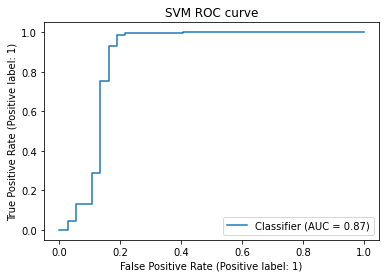

In [41]:
RocCurveDisplay.from_predictions(np.asarray(test_result), np.max(predictions, axis=1)) 
plt.title("SVM ROC curve")
plt.show()

<h5>plot sample of images</h5>

In [ ]:
fig = plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)


plt.subplot(3, 3, 1)
image = Image.open(tt[0])
im = np.array(image) 
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 2)
image = Image.open(tt[1])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 3)
image = Image.open(tt[2])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 4)
image = Image.open(tt[3])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(3, 3, 5)
image = Image.open(tt[4])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 6)
image = Image.open(tt[5])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 7)
image = Image.open(tt[6])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 8)
image = Image.open(tt[7])
im = np.array(image) 
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplot(3, 3, 9)
image = Image.open(tt[8])
im = np.array(image)
plt.imshow(im, cmap="gray")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.subplots_adjust(left=.1,
                    bottom=.1, 
                    right=.9, 
                    top=.9, 
                    wspace=.0005, 
                    hspace=.2)
#plt.show()

plt.savefig('example_training_images.png')

In [ ]:
sklearn.metrics.SCORERS.keys()